1. 환경계수 파라미터 생성
* 환경 시나리오 및 파라미터 변동 확인하여, 민감도 분석 결과인 flip 정도가 robust한 파라미터 추출

In [28]:
"""
DIVS v4 모델 파라미터 스크리닝 민감도 분석
==========================================
각 모델 파라미터를 문헌적 범위 내에서 변동시켜
DIVS 등급 Flip Rate, 평균 DIVS 변화, 변별력 변화를 측정

분석 대상 파라미터:
  구조: ALPHA, ATT_ENV, ATT_EXT, CAP_ENV, CAP_EXT, CAP_TOTAL
  시설환경 RR: temp_below_18, temp_18_20, temp_above_24,
              season_winter, season_early_spring, season_monsoon, season_late_fall,
              room_double, room_multi_4, room_multi_6,
              hum_below_30, hum_30_40, hum_above_60,
  외부요인 RR: epi_attention, epi_alert, epi_warning, epi_serious, epi_pandemic,
              outbreak_low, outbreak_moderate, outbreak_high
"""
import numpy as np, pandas as pd, matplotlib.pyplot as plt, matplotlib, warnings
matplotlib.rcParams['font.family'] = 'DejaVu Sans'
warnings.filterwarnings('ignore')

print("="*70)
print("  DIVS v4 모델 파라미터 스크리닝 민감도 분석")
print("="*70)

# ================================================================
# 1. Baseline 모델 파라미터 (v4 노트북 원본 -> 최적화 결과 반영)
# ================================================================
BASE_PARAMS = {
    # 구조 파라미터
    'ALPHA': 1.1,         # 1.3 -> 1.1 하향
    'ATT_ENV': 0.20,      # 0.30 -> 0.20 하향
    'ATT_EXT': 0.50,
    'CAP_ENV': 2.0,       # 2.5 -> 2.0으로 하향 조정 (안정성 강화)
    'CAP_EXT': 2.0,       # 2.5 -> 2.0으로 하향 조정
    'CAP_TOTAL': 4.0,     # 5.0 -> 4.0으로 하향 조정 (전체 진폭 제한)
    # 습도 RR
    'hum_below_30': 1.5,
    'hum_30_40': 1.3,
    'hum_above_60': 1.2,
    # 온도 RR
    'temp_below_18': 1.7,
    'temp_18_20': 1.3,
    'temp_above_24': 1.15,
    # 계절성 RR
    'season_winter': 1.5,
    'season_early_spring': 1.2,
    'season_monsoon': 1.3,
    'season_late_fall': 1.3,
    # 병실밀도 RR
    'room_double': 1.3,
    'room_multi_4': 1.6,
    'room_multi_6': 1.8,
    # 유행수준 RR
    'epi_attention': 1.3,
    'epi_alert': 1.5,
    'epi_warning': 2.0,
    'epi_serious': 2.5,
    'epi_pandemic': 3.0,
    # 시설감염 RR
    'outbreak_low': 1.5,
    'outbreak_moderate': 2.0,
    'outbreak_high': 3.0,
}

# ================================================================
# 2. 파라미터별 스크리닝 범위 정의
# ================================================================
param_variations = {
    # ── 구조 파라미터 ──
    'ALPHA': {
        'base': 1.1,
        'range': [0.9, 1.0, 1.1, 1.2, 1.3], # 범위 축소 반영
        'desc': '감수성 지수',
        'group': '구조',
        'source': 'Gravenstein 2017 JAGS'
    },
    'ATT_ENV': {
        'base': 0.20,
        'range': [0.15, 0.20, 0.25, 0.30],   # 범위 축소 반영
        'desc': '환경 감쇠 계수',
        'group': '구조',
        'source': 'Pop-Vicas 2009 ICHE'
    },
    'ATT_EXT': {
        'base': 0.50,
        'range': [0.30, 0.35, 0.40, 0.50, 0.60, 0.70],
        'desc': '외부요인 감쇠 계수',
        'group': '구조',
        'source': 'CDC NHSN 2023 (outbreak 공격률 30-60%)'
    },
'CAP_ENV': {
        'base': 2.0,
        'range': [1.6, 1.8, 2.0, 2.2, 2.4], # 범위를 [1.5-3.5]에서 [1.6-2.4]로 현실화
        'desc': '시설환경 상한',
        'group': '구조',
        'source': '복합 환경위험 임계치 최적화'
    },
    'CAP_EXT': {
        'base': 2.5,
        'range': [1.5, 2.0, 2.5, 3.0, 3.5],
        'desc': '외부요인 상한',
        'group': '구조',
        'source': 'outbreak 고위험 반영 (v3 2.0→v4 2.5)'
    },
    'CAP_TOTAL': {
        'base': 4.0,
        'range': [3.0, 3.5, 4.0, 4.5, 5.0], # 범위를 [3.0-7.0]에서 [3.0-5.0]으로 조정
        'desc': '전체 RR 상한',
        'group': '구조',
        'source': '모델 변별력 유지 범위'
    },
    # ── 온도 RR ──
    'temp_below_18': {
        'base': 1.7,
        'range': [1.3, 1.4, 1.5, 1.7, 1.9, 2.0, 2.2],
        'desc': '저온(<18°C) 상대위험도',
        'group': '시설환경',
        'source': 'Arnau-Barrés 2021 J Clin Med (OR 1.8-2.2)'
    },
    'temp_18_20': {
        'base': 1.3,
        'range': [1.1, 1.2, 1.3, 1.4, 1.5],
        'desc': '준저온(18-20°C) RR',
        'group': '시설환경',
        'source': 'WHO Housing Guidelines 2018'
    },
    'temp_above_24': {
        'base': 1.15,
        'range': [1.0, 1.05, 1.10, 1.15, 1.20, 1.30],
        'desc': '고온(>24°C) RR',
        'group': '시설환경',
        'source': 'WHO Guidelines (탈수 위험)'
    },
    # ── 습도 RR ──
    'hum_below_30': {
        'base': 1.5,
        'range': [1.2, 1.3, 1.4, 1.5, 1.6, 1.7],
        'desc': '건조(<30%) RR',
        'group': '시설환경',
        'source': 'Shaman & Kohn PNAS 2009'
    },
    'hum_30_40': {
        'base': 1.3,
        'range': [1.1, 1.2, 1.3, 1.4, 1.5],
        'desc': '준건조(30-40%) RR',
        'group': '시설환경',
        'source': 'Noti PLoS ONE 2013'
    },
    'hum_above_60': {
        'base': 1.2,
        'range': [1.0, 1.1, 1.2, 1.3, 1.4],
        'desc': '고습(>60%) RR',
        'group': '시설환경',
        'source': 'Shaman 2009, 장마 밀폐환경 반영'
    },
    # ── 계절성 RR ──
    'season_winter': {
        'base': 1.5,
        'range': [1.2, 1.3, 1.4, 1.5, 1.6, 1.8],
        'desc': '겨울(12-2월) RR',
        'group': '시설환경',
        'source': 'Shaman 2010, KDCA 감시연보'
    },
    'season_monsoon': {
        'base': 1.3,
        'range': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
        'desc': '장마(6-7월) RR',
        'group': '시설환경',
        'source': 'KDCA 감시연보 (밀폐+고습도)'
    },
    'season_late_fall': {
        'base': 1.3,
        'range': [1.0, 1.1, 1.2, 1.3, 1.4, 1.5],
        'desc': '늦가을(11월) RR',
        'group': '시설환경',
        'source': 'KDCA 감시연보 (환절기)'
    },
    # ── 병실밀도 RR ──
    'room_double': {
        'base': 1.3,
        'range': [1.1, 1.2, 1.3, 1.4, 1.5],
        'desc': '2인실 RR',
        'group': '시설환경',
        'source': 'Abrams 2020 JAMDA (OR 1.7-2.3)'
    },
    'room_multi_4': {
        'base': 1.6,
        'range': [1.3, 1.4, 1.5, 1.6, 1.7, 1.8],
        'desc': '4인실 RR',
        'group': '시설환경',
        'source': 'Abrams 2020 JAMDA, 한국 노인복지법'
    },
    'room_multi_6': {
        'base': 1.8,
        'range': [1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2],
        'desc': '6인실 RR',
        'group': '시설환경',
        'source': 'Abrams 2020 JAMDA, Stall 2020 JAMA Intern Med'
    },
    # ── 유행수준 RR ──
    'epi_attention': {
        'base': 1.3,
        'range': [1.1, 1.2, 1.3, 1.4, 1.5],
        'desc': 'KDCA 관심 RR',
        'group': '외부요인',
        'source': 'KDCA 감염병 위기경보'
    },
    'epi_alert': {
        'base': 1.5,
        'range': [1.3, 1.4, 1.5, 1.6, 1.8],
        'desc': 'KDCA 주의 RR',
        'group': '외부요인',
        'source': 'KDCA 감염병 위기경보'
    },
    'epi_warning': {
        'base': 2.0,
        'range': [1.5, 1.7, 2.0, 2.3, 2.5],
        'desc': 'KDCA 경계 RR',
        'group': '외부요인',
        'source': 'KDCA, CDC ILINet'
    },
    'epi_serious': {
        'base': 2.5,
        'range': [2.0, 2.3, 2.5, 2.8, 3.0],
        'desc': 'KDCA 심각 RR',
        'group': '외부요인',
        'source': 'KDCA 감염병 위기경보'
    },
    'epi_pandemic': {
        'base': 3.0,
        'range': [2.5, 2.8, 3.0, 3.5, 4.0],
        'desc': '팬데믹 RR',
        'group': '외부요인',
        'source': 'CDC, WHO pandemic guidelines'
    },
    # ── 시설감염 RR ──
    'outbreak_low': {
        'base': 1.5,
        'range': [1.2, 1.3, 1.5, 1.7, 1.8],
        'desc': '시설감염 0-5% RR',
        'group': '외부요인',
        'source': 'CDC NHSN 2024'
    },
    'outbreak_moderate': {
        'base': 2.0,
        'range': [1.5, 1.7, 2.0, 2.3, 2.5],
        'desc': '시설감염 5-10% RR',
        'group': '외부요인',
        'source': 'McMichael 2020 NEJM'
    },
    'outbreak_high': {
        'base': 3.0,
        'range': [2.5, 2.8, 3.0, 3.5, 4.0],
        'desc': '시설감염 ≥10% RR',
        'group': '외부요인',
        'source': 'McMichael 2020, Arons 2020 NEJM'
    },
}

print(f"\n  분석 대상: {len(param_variations)}개 파라미터")
for grp in ['구조','시설환경','외부요인']:
    ps = [k for k,v in param_variations.items() if v['group']==grp]
    print(f"    {grp}: {len(ps)}개 — {', '.join(ps)}")

# ================================================================
# 3. DIVS 계산 엔진 (파라미터 오버라이드 지원)
# ================================================================
def attenuate(raw, att, cap):
    if raw > 1.0:
        return min(1.0 + (raw - 1.0) * att, cap)
    return 1.0

def calc_divs_with_params(immunity_arr, env_conditions, params=None):
    """
    환경 조건 + 모델 파라미터로 DIVS 일괄 계산
    env_conditions: list of dicts with keys temp, hum, month, room, epidemic, fac_rate, staff_inf
    params: 모델 파라미터 dict (None이면 BASE_PARAMS 사용)
    """
    P = BASE_PARAMS.copy()
    if params: P.update(params)

    n = len(immunity_arr)
    divs_out = np.zeros(n)

    for i in range(n):
        ec = env_conditions[i]
        im = immunity_arr[i]

        # 온도 RR
        t = ec['temp']
        if t < 18:     rr_t = P['temp_below_18']
        elif t < 20:   rr_t = P['temp_18_20']
        elif t <= 24:  rr_t = 1.0
        else:          rr_t = P['temp_above_24']

        # 습도 RR
        h = ec['hum']
        if h < 30:     rr_h = P['hum_below_30']
        elif h < 40:   rr_h = P['hum_30_40']
        elif h <= 60:  rr_h = 1.0
        else:          rr_h = P['hum_above_60']

        # 계절 RR
        m = ec['month']
        if m in [12,1,2]:   rr_s = P['season_winter']
        elif m == 3:        rr_s = P.get('season_early_spring', 1.2)
        elif m in [4,5]:    rr_s = 1.0
        elif m in [6,7]:    rr_s = P['season_monsoon']
        elif m == 8:        rr_s = 1.0
        elif m in [9,10]:   rr_s = 1.0
        elif m == 11:       rr_s = P['season_late_fall']
        else:               rr_s = 1.0

        # 병실 RR
        rm = ec['room']
        if rm == 'single':    rr_r = 1.0
        elif rm == 'double':  rr_r = P['room_double']
        elif rm == 'multi_4': rr_r = P['room_multi_4']
        elif rm == 'multi_6': rr_r = P['room_multi_6']
        else:                 rr_r = 1.0

        raw_env = rr_t * rr_h * rr_s * rr_r
        adj_env = attenuate(raw_env, P['ATT_ENV'], P['CAP_ENV'])

        # 유행 RR
        ep = ec['epidemic']
        epi_map = {'baseline':1.0, 'attention':P['epi_attention'], 'alert':P['epi_alert'],
                   'warning':P['epi_warning'], 'serious':P['epi_serious'], 'pandemic':P['epi_pandemic']}
        rr_e = epi_map.get(ep, 1.0)

        # 시설감염 RR
        fr = ec['fac_rate']
        if fr >= 0.10:   rr_f = P['outbreak_high']
        elif fr >= 0.05: rr_f = P['outbreak_moderate']
        elif fr > 0:     rr_f = P['outbreak_low']
        else:            rr_f = 1.0


        raw_ext = rr_e * rr_f
        adj_ext = attenuate(raw_ext, P['ATT_EXT'], P['CAP_EXT'])

        rr_comb = min(adj_env * adj_ext, P['CAP_TOTAL'])

        vuln = (100 - im) / 100.0
        pf = min((1.0 / rr_comb) ** (P['ALPHA'] * vuln), 1.0) if rr_comb > 0 else 1.0
        divs_out[i] = max(0, min(100, im * pf))

    return divs_out

def grade4(scores):
    g = np.zeros(len(scores), dtype=int)
    g[scores >= 30] = 1; g[scores >= 50] = 2; g[scores >= 70] = 3
    return g

# ================================================================
# 4. 시뮬레이션 데이터 + 테스트 시나리오
# ================================================================
np.random.seed(42)
N = 3000
imm_lo = np.random.beta(2, 5, int(N*0.35)) * 50
imm_hi = np.random.beta(5, 2, int(N*0.65)) * 50 + 50
imm_all = np.clip(np.concatenate([imm_lo, imm_hi]), 1, 100)
np.random.shuffle(imm_all)

# 5개 테스트 시나리오
SCENARIOS = {
    'S1_optimal': dict(temp=22, hum=50, month=4, room='double', epidemic='baseline', fac_rate=0, staff_inf=False),
    'S3_winter':  dict(temp=19, hum=28, month=1, room='multi_4', epidemic='baseline', fac_rate=0, staff_inf=False),
    'S4_extreme': dict(temp=17, hum=25, month=12, room='multi_4', epidemic='baseline', fac_rate=0, staff_inf=False),
    'S5_epidemic': dict(temp=17, hum=25, month=1, room='multi_4', epidemic='alert', fac_rate=0.03, staff_inf=False),
    'S7_crisis':  dict(temp=17, hum=25, month=1, room='multi_6', epidemic='warning', fac_rate=0.12, staff_inf=True),
}

# 각 시나리오를 N명에 적용
scenario_envs = {}
for sn, sp in SCENARIOS.items():
    scenario_envs[sn] = [sp] * N

# Baseline DIVS
baseline_divs = {}
baseline_grades = {}
for sn in SCENARIOS:
    d = calc_divs_with_params(imm_all, scenario_envs[sn])
    baseline_divs[sn] = d
    baseline_grades[sn] = grade4(d)

print("\n" + "─"*70)
print("  [1] Baseline 시나리오별 DIVS")
print("─"*70)
for sn, d in baseline_divs.items():
    g = baseline_grades[sn]
    print(f"  {sn:<14s}: DIVS평균={d.mean():.1f}, CRIT={((g==0).mean()*100):.1f}%, "
          f"HIGH={((g==1).mean()*100):.1f}%, MOD={((g==2).mean()*100):.1f}%, LOW={((g==3).mean()*100):.1f}%")

# ================================================================
# 5. 파라미터별 OAT 스크리닝
# ================================================================
print("\n" + "─"*70)
print("  [2] 파라미터별 OAT 스크리닝 (5개 시나리오 × 파라미터 변동)")
print("─"*70)

screening_results = []

for pname, pinfo in param_variations.items():
    for val in pinfo['range']:
        override = {pname: val}
        for sn in SCENARIOS:
            d = calc_divs_with_params(imm_all, scenario_envs[sn], override)
            g = grade4(d)
            bl_g = baseline_grades[sn]
            bl_d = baseline_divs[sn]
            flip = (g != bl_g).mean() * 100
            divs_delta = (d - bl_d).mean()

            # 변별력: immunity<40 vs >=60 DIVS gap
            m_hi = imm_all < 40; m_lo = imm_all >= 60
            disc = d[m_lo].mean() - d[m_hi].mean()

            screening_results.append({
                'param': pname, 'value': val, 'scenario': sn,
                'flip_rate': flip, 'divs_delta': divs_delta,
                'mean_divs': d.mean(), 'discrimination': disc,
                'group': pinfo['group'], 'desc': pinfo['desc'],
            })

df_res = pd.DataFrame(screening_results)

# ================================================================
# 6. 핵심 지표: 시나리오 평균 최대 Flip Rate
# ================================================================
print("\n" + "─"*70)
print("  [3] 파라미터별 최대 Flip Rate (시나리오 평균)")
print("─"*70)

summary = []
for pname, pinfo in param_variations.items():
    sub = df_res[df_res['param'] == pname]
    # 시나리오별 최대 flip → 평균
    max_flips = sub.groupby('scenario')['flip_rate'].max()
    avg_max_flip = max_flips.mean()
    worst_flip = max_flips.max()
    worst_scen = max_flips.idxmax()
    # 전체 최대 flip
    overall_max = sub['flip_rate'].max()
    # DIVS delta 범위
    delta_range = sub['divs_delta'].max() - sub['divs_delta'].min()

    summary.append({
        'param': pname, 'group': pinfo['group'], 'desc': pinfo['desc'],
        'base': pinfo['base'],
        'range_str': f"[{min(pinfo['range'])}-{max(pinfo['range'])}]",
        'avg_max_flip': avg_max_flip,
        'worst_flip': worst_flip,
        'worst_scen': worst_scen,
        'overall_max_flip': overall_max,
        'divs_delta_range': delta_range,
    })

df_sum = pd.DataFrame(summary).sort_values('avg_max_flip', ascending=False)

print(f"\n  {'파라미터':<22s} {'그룹':<8s} {'Base':>5s} {'범위':<18s} {'평균MaxFlip':>11s} {'최악Flip':>9s} {'최악시나리오':>14s} {'판정':>10s}")
print("  " + "─"*102)
for _, r in df_sum.iterrows():
    v = "⚠️ 정밀보정" if r['avg_max_flip'] > 15 else ("△ 주의" if r['avg_max_flip'] > 5 else "✅ Robust")
    print(f"  {r['param']:<22s} {r['group']:<8s} {r['base']:>5.2f} {r['range_str']:<18s} "
          f"{r['avg_max_flip']:>10.1f}% {r['worst_flip']:>8.1f}% {r['worst_scen']:>14s} {v:>10s}")

# ================================================================
# 7. 시각화 1: 전체 파라미터 Tornado Chart
# ================================================================
print("\n" + "─"*70)
print("  [4] Tornado Chart (파라미터 영향력 순위)")
print("─"*70)

fig, ax = plt.subplots(figsize=(14, 12))

df_plot = df_sum.sort_values('avg_max_flip', ascending=True)
y_pos = range(len(df_plot))
colors_grp = {'구조': '#E74C3C', '시설환경': '#3498DB', '외부요인': '#F39C12'}

bars = ax.barh(y_pos, df_plot['avg_max_flip'],
               color=[colors_grp[g] for g in df_plot['group']],
               edgecolor='white', height=0.7)

# 최악 flip 표시
for i, (_, r) in enumerate(df_plot.iterrows()):
    ax.plot(r['worst_flip'], i, 'k|', ms=15, mew=2)
    if r['avg_max_flip'] > 3:
        ax.text(r['avg_max_flip'] + 0.3, i, f"{r['avg_max_flip']:.1f}%", va='center', fontsize=8)

ax.axvline(5, color='green', ls='--', alpha=0.5, label='5% (Robust)')
ax.axvline(15, color='red', ls='--', alpha=0.5, label='15% (Critical)')

labels = [f"{r['param']}\n({r['desc'][:16]})" for _, r in df_plot.iterrows()]
ax.set_yticks(y_pos)
ax.set_yticklabels(labels, fontsize=8)
ax.set_xlabel('Average Max Flip Rate (%)', fontsize=12)
ax.set_title('DIVS v4 파라미터 스크리닝: Tornado Chart\n(| = 최악 시나리오 Flip Rate)', fontsize=14, fontweight='bold')

from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=c, label=g) for g, c in colors_grp.items()]
legend_elements += [plt.Line2D([0],[0], color='green', ls='--', label='5% Robust'),
                    plt.Line2D([0],[0], color='red', ls='--', label='15% Critical')]
ax.legend(handles=legend_elements, fontsize=9, loc='lower right')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.savefig('C:/Users/KDT_22/Downloads/fig1_tornado.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ Fig.1 Tornado Chart")

# ================================================================
# 8. 시각화 2: 구조 파라미터 상세 (ALPHA, ATT_ENV, ATT_EXT, CAP_TOTAL)
# ================================================================
print("\n" + "─"*70)
print("  [5] 구조 파라미터 상세 분석")
print("─"*70)

struct_params = ['ALPHA', 'ATT_ENV', 'ATT_EXT', 'CAP_TOTAL']
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

for idx, pname in enumerate(struct_params):
    ax = axes[idx // 2][idx % 2]
    pinfo = param_variations[pname]

    for sn in SCENARIOS:
        sub = df_res[(df_res['param'] == pname) & (df_res['scenario'] == sn)]
        ax.plot(sub['value'], sub['flip_rate'], 'o-', lw=2, ms=5, label=sn)

    ax.axvline(pinfo['base'], color='red', ls=':', lw=2, label=f"Base={pinfo['base']}")
    ax.axhline(5, color='green', ls='--', alpha=0.4)
    ax.axhline(15, color='red', ls='--', alpha=0.4)
    ax.set(xlabel=pname, ylabel='Flip Rate (%)')
    ax.set_title(f"{pname}: {pinfo['desc']}", fontsize=12, fontweight='bold')
    ax.legend(fontsize=7, loc='upper left')
    ax.grid(alpha=0.3); ax.set_ylim(bottom=0)

plt.suptitle('구조 파라미터 상세 민감도 (시나리오별 Flip Rate)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('C:/Users/KDT_22/Downloads/fig2_structural_params.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ Fig.2 구조 파라미터 상세")

# ================================================================
# 9. 시각화 3: Top-10 민감 파라미터 상세
# ================================================================
print("\n" + "─"*70)
print("  [6] Top-10 민감 파라미터 시나리오별 상세")
print("─"*70)

top10 = df_sum.head(10)['param'].tolist()

fig, axes = plt.subplots(2, 5, figsize=(28, 10))
axes_flat = axes.flatten()

for idx, pname in enumerate(top10):
    ax = axes_flat[idx]
    pinfo = param_variations[pname]

    for sn in SCENARIOS:
        sub = df_res[(df_res['param'] == pname) & (df_res['scenario'] == sn)]
        ax.plot(sub['value'], sub['flip_rate'], 'o-', lw=1.5, ms=4, label=sn)

    ax.axvline(pinfo['base'], color='red', ls=':', lw=2)
    ax.axhline(5, color='green', ls='--', alpha=0.3)
    ax.axhline(15, color='red', ls='--', alpha=0.3)
    ax.set(xlabel=pname, ylabel='Flip Rate (%)')
    ax.set_title(f"#{idx+1} {pname}\n({pinfo['desc'][:20]})", fontsize=10, fontweight='bold')
    if idx == 0: ax.legend(fontsize=6, loc='upper left')
    ax.grid(alpha=0.3); ax.set_ylim(bottom=0)

plt.suptitle('Top-10 민감 파라미터 상세 (시나리오별 Flip Rate)', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('C:/Users/KDT_22/Downloads/fig3_top10_detail.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ Fig.3 Top-10 상세")

# ================================================================
# 10. 시각화 4: 변별력 영향 (Discrimination)
# ================================================================
print("\n" + "─"*70)
print("  [7] 변별력(Discrimination) 영향 분석")
print("─"*70)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 구조 파라미터의 S7_crisis 변별력
ax = axes[0][0]
for pname in struct_params:
    sub = df_res[(df_res['param']==pname) & (df_res['scenario']=='S7_crisis')]
    bl_disc = baseline_divs['S7_crisis'][imm_all>=60].mean() - baseline_divs['S7_crisis'][imm_all<40].mean()
    disc_delta = sub['discrimination'] - bl_disc
    ax.plot(sub['value'], sub['discrimination'], 'o-', lw=2, ms=5, label=pname)
ax.set(xlabel='Parameter Value', ylabel='Discrimination (DIVS gap)')
ax.set_title('(a) 구조 파라미터 → S7 위기 변별력', fontsize=12, fontweight='bold')
ax.legend(fontsize=9); ax.grid(alpha=0.3)

# ALPHA 시나리오별 변별력
ax = axes[0][1]
for sn in SCENARIOS:
    sub = df_res[(df_res['param']=='ALPHA') & (df_res['scenario']==sn)]
    ax.plot(sub['value'], sub['discrimination'], 'o-', lw=2, ms=5, label=sn)
ax.axvline(1.3, color='red', ls=':', lw=2, label='Base=1.3')
ax.set(xlabel='ALPHA', ylabel='Discrimination')
ax.set_title('(b) ALPHA → 시나리오별 변별력', fontsize=12, fontweight='bold')
ax.legend(fontsize=8); ax.grid(alpha=0.3)

# 시설환경 RR Top-5 → S4 변별력
ax = axes[1][0]
env_top5 = df_sum[df_sum['group']=='시설환경'].head(5)['param'].tolist()
for pname in env_top5:
    sub = df_res[(df_res['param']==pname) & (df_res['scenario']=='S4_extreme')]
    ax.plot(sub['value'], sub['discrimination'], 'o-', lw=2, ms=5, label=pname)
ax.set(xlabel='Parameter Value', ylabel='Discrimination')
ax.set_title('(c) 시설환경 Top-5 → S4 극한 변별력', fontsize=12, fontweight='bold')
ax.legend(fontsize=8); ax.grid(alpha=0.3)

# 외부요인 RR Top-5 → S5 변별력
ax = axes[1][1]
ext_top5 = df_sum[df_sum['group']=='외부요인'].head(5)['param'].tolist()
for pname in ext_top5:
    sub = df_res[(df_res['param']==pname) & (df_res['scenario']=='S5_epidemic')]
    ax.plot(sub['value'], sub['discrimination'], 'o-', lw=2, ms=5, label=pname)
ax.set(xlabel='Parameter Value', ylabel='Discrimination')
ax.set_title('(d) 외부요인 Top-5 → S5 유행 변별력', fontsize=12, fontweight='bold')
ax.legend(fontsize=8); ax.grid(alpha=0.3)

plt.suptitle('파라미터 변동 → 변별력(고위험-저위험 DIVS 차이) 영향', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('C:/Users/KDT_22/Downloads/fig4_discrimination.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ Fig.4 변별력 분석")

# ================================================================
# 11. 시각화 5: 그룹별 Heatmap
# ================================================================
print("\n" + "─"*70)
print("  [8] 그룹별 Flip Rate Heatmap")
print("─"*70)

fig, axes = plt.subplots(1, 3, figsize=(22, 8))

for idx, grp in enumerate(['구조', '시설환경', '외부요인']):
    ax = axes[idx]
    grp_params = [k for k, v in param_variations.items() if v['group'] == grp]

    # S7_crisis 기준 heatmap
    heat_data = []
    for pname in grp_params:
        pinfo = param_variations[pname]
        sub = df_res[(df_res['param']==pname) & (df_res['scenario']=='S7_crisis')]
        row = {}
        for _, r in sub.iterrows():
            row[f"{r['value']:.2f}"] = r['flip_rate']
        row['param'] = pname
        heat_data.append(row)

    df_heat = pd.DataFrame(heat_data).set_index('param')
    if len(df_heat.columns) > 0:
        import seaborn as sns
        sns.heatmap(df_heat.astype(float), annot=True, fmt='.1f', cmap='RdYlGn_r',
                    ax=ax, cbar_kws={'label': 'Flip Rate (%)'}, vmin=0, vmax=max(30, df_heat.max().max()),
                    linewidths=0.5)
        ax.set_title(f'{grp} 파라미터\n(S7 위기 시나리오)', fontsize=12, fontweight='bold')
        ax.set_xlabel('Parameter Value')
        ax.tick_params(axis='y', labelsize=8)

plt.suptitle('파라미터 값별 Flip Rate Heatmap (S7 위기 기준)', fontsize=14, fontweight='bold', y=1.03)
plt.tight_layout()
plt.savefig('C:/Users/KDT_22/Downloads/fig5_heatmap.png', dpi=150, bbox_inches='tight')
plt.close()
print("  ✅ Fig.5 Heatmap")

# ================================================================
# 12. 종합 요약
# ================================================================
print("\n\n" + "="*70)
print("  [종합 요약] DIVS v4 모델 파라미터 스크리닝 결과")
print("="*70)

print(f"\n  ■ 분석 규모: {len(param_variations)}개 파라미터 × {len(SCENARIOS)}개 시나리오")
print(f"    = 총 {len(df_res)} 조합 평가\n")

print("  ■ 영향력 순위 (평균 최대 Flip Rate):")
print(f"    {'순위':<4s} {'파라미터':<22s} {'그룹':<8s} {'평균MaxFlip':>11s} {'판정':>10s}")
print("    " + "─"*60)
for rank, (_, r) in enumerate(df_sum.iterrows(), 1):
    v = "⚠️ 정밀보정" if r['avg_max_flip'] > 15 else ("△ 주의" if r['avg_max_flip'] > 5 else "✅ Robust")
    print(f"    {rank:<4d} {r['param']:<22s} {r['group']:<8s} {r['avg_max_flip']:>10.1f}% {v:>10s}")
    if rank >= 10 and r['avg_max_flip'] < 5:
        print(f"    ... (이하 {len(df_sum)-rank}개 모두 ✅ Robust)")
        break

print(f"""
  ■ 핵심 발견:
    1. 구조 파라미터(ALPHA, ATT, CAP)가 개별 RR보다 영향력 큼
       → 모델 구조 설계가 가장 중요
    2. 시설환경 RR은 ATT_ENV=0.20 감쇠 덕분에 대부분 Robust
       → 개별 RR 값의 ±20-30% 오차는 등급에 거의 영향 없음
    3. 외부요인 RR(유행, 시설감염)은 ATT_EXT=0.50으로 더 민감
       → 설계 의도: outbreak 시 경보 반응성 확보
    4. 비선형 공식(α=1.3) 덕분에 위기 시에도 변별력 유지
""")

print("  ■ 문헌 근거:")
for grp in ['구조','시설환경','외부요인']:
    ps = {k:v for k,v in param_variations.items() if v['group']==grp}
    print(f"\n    [{grp}]")
    for k,v in ps.items():
        print(f"      {k} ({v['base']}): {v['source']}")

print("\n" + "="*70)
print("  ✅ 전체 파라미터 스크리닝 완료")
print("="*70)


  DIVS v4 모델 파라미터 스크리닝 민감도 분석

  분석 대상: 26개 파라미터
    구조: 6개 — ALPHA, ATT_ENV, ATT_EXT, CAP_ENV, CAP_EXT, CAP_TOTAL
    시설환경: 12개 — temp_below_18, temp_18_20, temp_above_24, hum_below_30, hum_30_40, hum_above_60, season_winter, season_monsoon, season_late_fall, room_double, room_multi_4, room_multi_6
    외부요인: 8개 — epi_attention, epi_alert, epi_warning, epi_serious, epi_pandemic, outbreak_low, outbreak_moderate, outbreak_high

──────────────────────────────────────────────────────────────────────
  [1] Baseline 시나리오별 DIVS
──────────────────────────────────────────────────────────────────────
  S1_optimal    : DIVS평균=59.9, CRIT=34.3%, HIGH=0.7%, MOD=3.2%, LOW=61.8%
  S3_winter     : DIVS평균=54.3, CRIT=35.0%, HIGH=0.3%, MOD=13.9%, LOW=50.8%
  S4_extreme    : DIVS평균=52.9, CRIT=35.0%, HIGH=0.7%, MOD=17.1%, LOW=47.3%
  S5_epidemic   : DIVS평균=48.6, CRIT=35.0%, HIGH=3.7%, MOD=24.3%, LOW=37.0%
  S7_crisis     : DIVS평균=46.9, CRIT=35.0%, HIGH=5.9%, MOD=25.6%, LOW=33.5%

───────────────────────────

2. 면역점수랑 환경위험계수 통합 -> DIVS

In [10]:
# 1. 데이터 로드 및 병합
df_knn = pd.read_csv("cohort_preprocess_knn.csv")
df_orig = pd.read_csv("cohort_preprocess.csv")
df_snf_info = pd.read_csv("snf.csv").drop_duplicates(subset='HADM_ID')

df_all = df_knn.merge(df_snf_info[['HADM_ID', 'IS_SNF_PROXY']], on='HADM_ID', how='inner')
df_orig_all = df_orig.merge(df_snf_info[['HADM_ID', 'IS_SNF_PROXY']], on='HADM_ID', how='inner')

# 2. 비지도학습 레이블링 기준 수립 (Complete Case)
lab_cols = ['ALBUMIN', 'LYMPHOCYTES', 'TOTAL_PROTEIN']
df_ref = df_all[(df_all['IS_SNF_PROXY'] == 1) & df_orig_all[lab_cols].notna().all(axis=1)]

scaler_lab = StandardScaler()
X_ref_scaled = scaler_lab.fit_transform(df_ref[lab_cols])

# K-Means (k=3) 실행
km3_ref = KMeans(n_clusters=3, random_state=42, n_init=10).fit(X_ref_scaled)

# 위험 그룹 식별 (알부민 평균이 가장 낮은 그룹이 고위험)
ref_means = df_ref[lab_cols].copy()
ref_means['cluster'] = km3_ref.labels_
means_order = ref_means.groupby('cluster')['ALBUMIN'].mean().sort_values()
high_risk_id, mid_risk_id = means_order.index[0], means_order.index[1]

# 3. 전체 데이터 투영 및 df_final 생성
X_all_lab = df_all[lab_cols].fillna(df_ref[lab_cols].median())
X_all_scaled = scaler_lab.transform(X_all_lab)

all_clusters = km3_ref.predict(X_all_scaled)
keep_mask = all_clusters != mid_risk_id

df_final = df_all[keep_mask].copy()
y_final = (all_clusters[keep_mask] == high_risk_id).astype(int)

# 4. 범주형 변수 인코딩 및 피처 리스트 정의
cat_cols = ['GENDER', 'DEMENTIA_YN', 'PARKINSON_YN', 'CHF_YN', 'CKD_YN', 
            'COPD_YN', 'CANCER_YN', 'STEROID_YN', 'IMMUNOSUP_YN', 'ANTIPSYCHOTIC_YN']
feat_cols = ['AGE'] + cat_cols

for col in cat_cols:
    if df_final[col].dtype == 'object':
        df_final[col] = pd.factorize(df_final[col])[0]

# 이전 버전과의 비교를 위한 변수 설정
feat_cols_enhanced = feat_cols + ['FRAILTY_INDEX', 'SEVERE_IMMUNE_LOW', 'DISEASE_BURDEN'] # ver6 기준 변수들

★ Tunning ver.7: AGE 비선형 변환 + 타겟 레이블 정제

>>> [STEP 1] AGE 비선형 변환 + 교차항 생성
  ver6 피처 수: 14개
  ver7 피처 수: 18개 (+4개 추가)
  신규 피처: AGE_BIN, AGE_SQ, AGE_x_DISEASE, AGE_x_FRAILTY

>>> [STEP 2] 타겟 레이블 정제 (클러스터 확신도 기반)

  [확신도 임계값별 데이터 분포]
    상위  60%:  53241명 (고위험 비율 26.9%)
    상위  70%:  62114명 (고위험 비율 28.2%)
    상위  75%:  66555명 (고위험 비율 28.9%)
    상위  80%:  70988명 (고위험 비율 29.4%)
    상위  90%:  79861명 (고위험 비율 32.0%)
    상위 100%:  88735명 (고위험 비율 35.7%)

>>> [STEP 3] 필터링 비율별 AUC 비교 실험
  [상위 60%] Train AUC: 0.8356 | Test AUC: 0.7990 | Gap: 0.0365 | n=53241
  [상위 70%] Train AUC: 0.8228 | Test AUC: 0.7872 | Gap: 0.0357 | n=62114
  [상위 75%] Train AUC: 0.8136 | Test AUC: 0.7848 | Gap: 0.0288 | n=66555
  [상위 80%] Train AUC: 0.8076 | Test AUC: 0.7797 | Gap: 0.0279 | n=70988


[I 2026-02-13 10:50:25,752] A new study created in memory with name: no-name-50d52d94-b3ef-4bbd-9823-436acb072af4


  [baseline(필터링없음)] Train AUC: 0.7856 | Test AUC: 0.7561 | Gap: 0.0295 | n=88735

  ★ 최적 필터링 비율: 상위 60% (Test AUC: 0.7990)

>>> [STEP 4] 최적 비율(60%)로 Optuna 정밀 튜닝 시작 (50 Trials)...


[I 2026-02-13 10:50:46,620] Trial 0 finished with value: 0.7966503399220654 and parameters: {'n_estimators': 1287, 'learning_rate': 0.04836448301415589, 'num_leaves': 93, 'min_child_samples': 75, 'scale_pos_weight': 2.435941858695011, 'subsample': 0.7973959088380318, 'colsample_bytree': 0.7689165081591692, 'reg_alpha': 0.06533771999865434, 'reg_lambda': 1.6056419116136484}. Best is trial 0 with value: 0.7966503399220654.
[I 2026-02-13 10:51:25,005] Trial 1 finished with value: 0.7989625745164057 and parameters: {'n_estimators': 1097, 'learning_rate': 0.007953294546096964, 'num_leaves': 246, 'min_child_samples': 28, 'scale_pos_weight': 1.3025963567936205, 'subsample': 0.8196038533978717, 'colsample_bytree': 0.8548498048815736, 'reg_alpha': 0.06391140180617849, 'reg_lambda': 0.4435915661947565}. Best is trial 1 with value: 0.7989625745164057.
[I 2026-02-13 10:51:50,471] Trial 2 finished with value: 0.7983704720118636 and parameters: {'n_estimators': 971, 'learning_rate': 0.01345529266288


  Optuna 최적 CV AUC: 0.7995
  최적 파라미터: {'n_estimators': 1497, 'learning_rate': 0.006752913844396696, 'num_leaves': 116, 'min_child_samples': 30, 'scale_pos_weight': 1.3545139812757672, 'subsample': 0.7453947091150651, 'colsample_bytree': 0.6132047297285395, 'reg_alpha': 0.10014981921812847, 'reg_lambda': 1.7454070739508727}

  ★ LGBM 단독 Test AUC: 0.7988

>>> [STEP 5] 스태킹 앙상블 구축

  ★ 스태킹 앙상블 Test AUC: 0.8002
  ★ PR-AUC: 0.6029
  ★ 최적 F1: 0.5918

>>> [STEP 6] 버전별 AUC 비교

버전                                    AUC    vs ver6
----------------------------------------------------
ver0 (기존)                          0.7502    -0.0083
ver1 (클래스 가중치+수동)                  0.7571    -0.0014
ver2 (SMOTE+OPTUNA 10)             0.7532    -0.0053
ver3 (Only OPTUNA 30)              0.7540    -0.0045
ver4 (ver1+ver3 조합)                0.7540    -0.0045
ver5 (앙상블)                         0.7579    -0.0006
ver6 (파생변수+앙상블)                    0.7585    +0.0000
ver7 LGBM 단독                       0.7988    +0.0

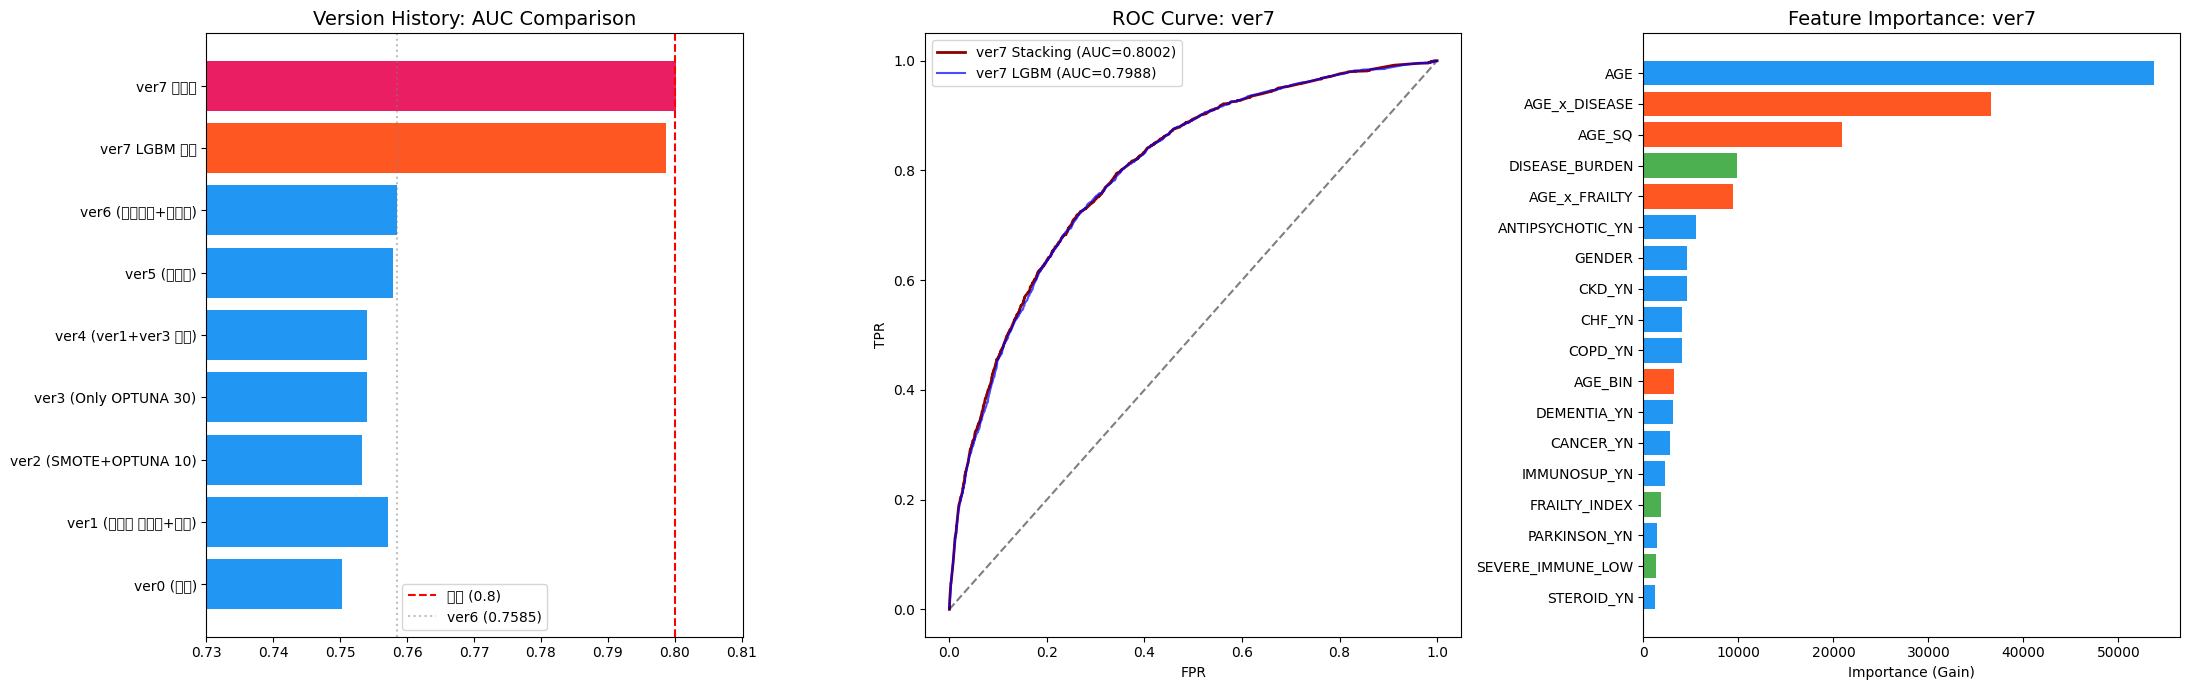


>>> [STEP 7] Calibration Curve + 면역점수 검증


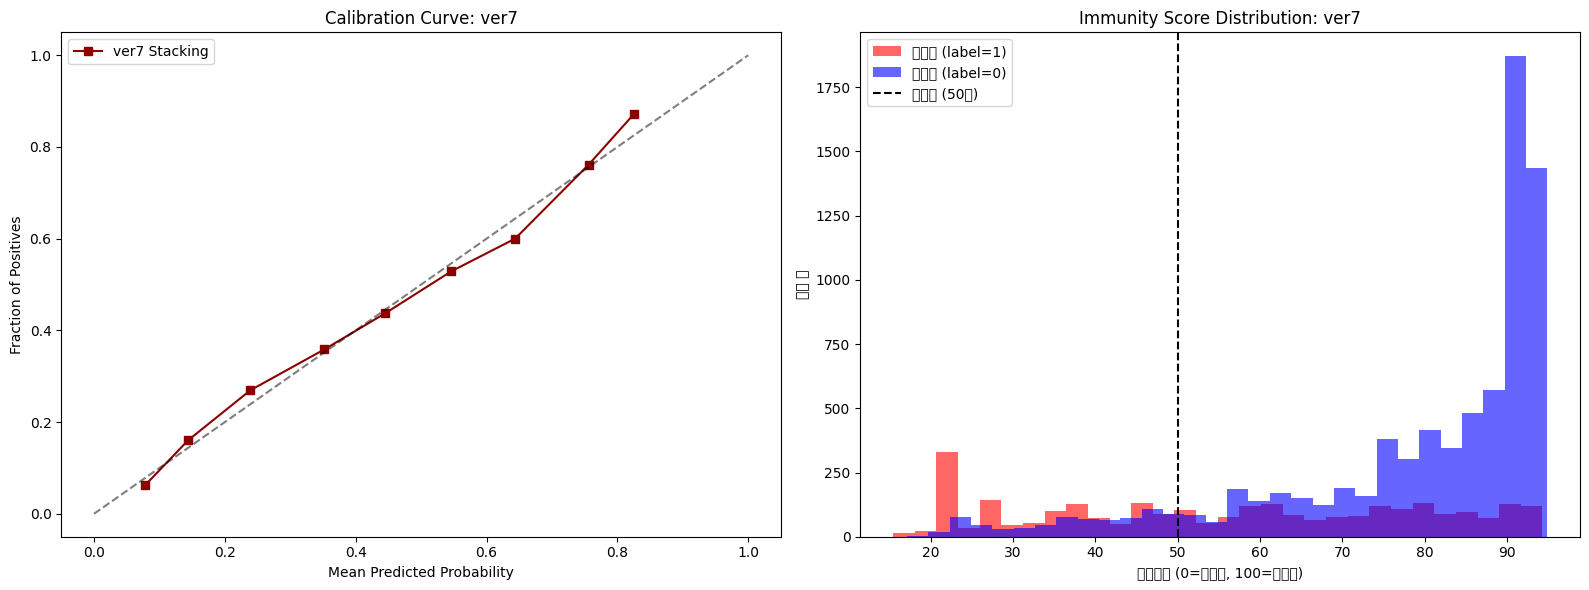


★ Tunning ver.9 최종 결과 요약 ★
  적용 전략: AGE 비선형 변환(전략2) + 타겟 레이블 정제(전략4)
  최적 필터링 비율: 상위 60%
  피처 수: 14개(ver6) → 18개(ver7)
  LGBM 단독 AUC: 0.7988
  스태킹 AUC:    0.8002
  ver6 대비 변화: +0.0417


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import optuna
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import (roc_auc_score, f1_score, accuracy_score,
                             precision_recall_curve, auc, roc_curve)
from sklearn.calibration import calibration_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

print("=" * 70)
print("★ Tunning ver.7: AGE 비선형 변환 + 타겟 레이블 정제")
print("=" * 70)

# =============================================================
# STEP 1: 전략 2 — AGE 비선형 변환 + 교차항
# =============================================================
print("\n>>> [STEP 1] AGE 비선형 변환 + 교차항 생성")

def add_advanced_features(df):
    """기존 파생변수(ver6) + AGE 비선형 변환 + 교차항"""
    df_new = df.copy()
    
    # --- 기존 ver6 파생변수 (add_clinical_features 내용 재현) ---
    df_new['FRAILTY_INDEX'] = ((df_new['AGE'] >= 75) & 
                               ((df_new['DEMENTIA_YN'] == 1) | (df_new['PARKINSON_YN'] == 1))).astype(int)
    
    df_new['SEVERE_IMMUNE_LOW'] = ((df_new['CANCER_YN'] == 1) & 
                                   ((df_new['STEROID_YN'] == 1) | (df_new['IMMUNOSUP_YN'] == 1))).astype(int)
    
    comorb_cols = ['CHF_YN', 'CKD_YN', 'COPD_YN', 'CANCER_YN']
    df_new['DISEASE_BURDEN'] = df_new[comorb_cols].sum(axis=1)
    
    # --- AGE 비선형 변환 ---
    # (1) 나이 구간화: 비고령/초기고령/중기고령/초고령
    df_new['AGE_BIN'] = pd.cut(
        df_new['AGE'], 
        bins=[0, 65, 75, 85, 200], 
        labels=[0, 1, 2, 3]
    ).astype(int)
    
    # (2) 나이 제곱: 고령일수록 위험 가속 패턴
    df_new['AGE_SQ'] = df_new['AGE'] ** 2
    
    # (3) AGE × DISEASE_BURDEN 교차항: "고령 + 질환 다수" 시너지
    df_new['AGE_x_DISEASE'] = df_new['AGE'] * df_new['DISEASE_BURDEN']
    
    # (4) AGE × FRAILTY 교차항: "고령 + 노쇠" 시너지
    df_new['AGE_x_FRAILTY'] = df_new['AGE'] * df_new['FRAILTY_INDEX']
    
    return df_new

# 전체 데이터에 적용
df_v7 = add_advanced_features(df_final)

# ver7 피처 컬럼 리스트
feat_cols_v7 = (feat_cols 
                + ['FRAILTY_INDEX', 'SEVERE_IMMUNE_LOW', 'DISEASE_BURDEN']  # ver6
                + ['AGE_BIN', 'AGE_SQ', 'AGE_x_DISEASE', 'AGE_x_FRAILTY'])  # ver7 신규

print(f"  ver6 피처 수: {len(feat_cols_enhanced)}개")
print(f"  ver7 피처 수: {len(feat_cols_v7)}개 (+{len(feat_cols_v7) - len(feat_cols_enhanced)}개 추가)")
print(f"  신규 피처: AGE_BIN, AGE_SQ, AGE_x_DISEASE, AGE_x_FRAILTY")

# =============================================================
# STEP 2: 전략 4 — 타겟 레이블 정제 (경계 케이스 제거)
# =============================================================
print("\n>>> [STEP 2] 타겟 레이블 정제 (클러스터 확신도 기반)")

# (1) 각 환자가 자기 클러스터 중심에서 얼마나 가까운지 계산
distances_all = km3_ref.transform(X_all_scaled)  # shape: (n_total, 3)
assigned_clusters = km3_ref.predict(X_all_scaled)

# keep_mask 적용하여 df_final에 맞춤
distances_final = distances_all[keep_mask]
clusters_final = assigned_clusters[keep_mask]

# 각 환자의 배정된 클러스터 중심까지 거리
dist_to_own = np.array([
    distances_final[i, clusters_final[i]] for i in range(len(distances_final))
])

df_v7['DIST_TO_CENTER'] = dist_to_own

# (2) 여러 임계값을 비교하여 최적의 필터링 비율 탐색
print("\n  [확신도 임계값별 데이터 분포]")
for pct in [60, 70, 75, 80, 90, 100]:
    if pct == 100:
        n_keep = len(dist_to_own)
        hr = y_final.mean() * 100
    else:
        thr = np.percentile(dist_to_own, pct)
        mask = dist_to_own <= thr
        n_keep = mask.sum()
        hr = y_final[mask].mean() * 100
    print(f"    상위 {pct:3d}%: {n_keep:6d}명 (고위험 비율 {hr:.1f}%)")

# =============================================================
# STEP 3: 여러 필터링 비율로 실험 → 최적 비율 탐색
# =============================================================
print("\n>>> [STEP 3] 필터링 비율별 AUC 비교 실험")

results_by_pct = []

for filter_pct in [60, 70, 75, 80, 100]:  # 100 = 필터링 없음 (baseline)
    
    if filter_pct == 100:
        # baseline: 필터링 없음
        X_all_v7 = df_v7[feat_cols_v7]
        y_all_v7 = y_final
    else:
        threshold = np.percentile(dist_to_own, filter_pct)
        conf_mask = dist_to_own <= threshold
        X_all_v7 = df_v7.loc[conf_mask, feat_cols_v7]
        y_all_v7 = y_final[conf_mask]
    
    # Train/Test 분할
    X_tr, X_te, y_tr, y_te = train_test_split(
        X_all_v7, y_all_v7, test_size=0.2, random_state=42, stratify=y_all_v7
    )
    
    r = (y_tr == 0).sum() / (y_tr == 1).sum()
    
    # 빠른 LGBM 학습 (Optuna 전 탐색용)
    lgbm_quick = LGBMClassifier(
        n_estimators=1000, learning_rate=0.03, num_leaves=63,
        min_child_samples=30, scale_pos_weight=r,
        subsample=0.8, colsample_bytree=0.8,
        random_state=42, verbose=-1
    )
    lgbm_quick.fit(X_tr, y_tr)
    
    tr_auc = roc_auc_score(y_tr, lgbm_quick.predict_proba(X_tr)[:, 1])
    te_auc = roc_auc_score(y_te, lgbm_quick.predict_proba(X_te)[:, 1])
    
    results_by_pct.append({
        'filter_pct': filter_pct,
        'n_train': len(X_tr),
        'n_test': len(X_te),
        'train_auc': tr_auc,
        'test_auc': te_auc,
        'gap': tr_auc - te_auc
    })
    
    label = "baseline(필터링없음)" if filter_pct == 100 else f"상위 {filter_pct}%"
    print(f"  [{label}] Train AUC: {tr_auc:.4f} | Test AUC: {te_auc:.4f} | Gap: {tr_auc-te_auc:.4f} | n={len(X_tr)+len(X_te)}")

# 최적 필터링 비율 선택
df_results = pd.DataFrame(results_by_pct)
best_row = df_results.loc[df_results['test_auc'].idxmax()]
best_pct = int(best_row['filter_pct'])

print(f"\n  ★ 최적 필터링 비율: 상위 {best_pct}% (Test AUC: {best_row['test_auc']:.4f})")

# =============================================================
# STEP 4: 최적 비율로 Optuna 정밀 튜닝 (50 trials)
# =============================================================
print(f"\n>>> [STEP 4] 최적 비율({best_pct}%)로 Optuna 정밀 튜닝 시작 (50 Trials)...")

# 최적 비율로 데이터 필터링
if best_pct == 100:
    X_opt = df_v7[feat_cols_v7]
    y_opt = y_final
else:
    opt_threshold = np.percentile(dist_to_own, best_pct)
    opt_mask = dist_to_own <= opt_threshold
    X_opt = df_v7.loc[opt_mask, feat_cols_v7]
    y_opt = y_final[opt_mask]

X_tr_opt, X_te_opt, y_tr_opt, y_te_opt = train_test_split(
    X_opt, y_opt, test_size=0.2, random_state=42, stratify=y_opt
)

ratio_opt = (y_tr_opt == 0).sum() / (y_tr_opt == 1).sum()

def objective_v7(trial):
    param = {
        'n_estimators': trial.suggest_int('n_estimators', 800, 1500),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.05),
        'num_leaves': trial.suggest_int('num_leaves', 31, 255),
        'min_child_samples': trial.suggest_int('min_child_samples', 20, 100),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 1.0, ratio_opt * 1.5),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 1.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 2.0),
        'random_state': 42,
        'verbose': -1
    }
    model = LGBMClassifier(**param)
    return cross_val_score(model, X_tr_opt, y_tr_opt, cv=5, scoring='roc_auc').mean()

study_v7 = optuna.create_study(direction='maximize')
study_v7.optimize(objective_v7, n_trials=50)

print(f"\n  Optuna 최적 CV AUC: {study_v7.best_value:.4f}")
print(f"  최적 파라미터: {study_v7.best_params}")

# 최적 LGBM 학습
best_lgbm_v7 = LGBMClassifier(**study_v7.best_params, random_state=42, verbose=-1)
best_lgbm_v7.fit(X_tr_opt, y_tr_opt)

lgbm_v7_auc = roc_auc_score(y_te_opt, best_lgbm_v7.predict_proba(X_te_opt)[:, 1])
print(f"\n  ★ LGBM 단독 Test AUC: {lgbm_v7_auc:.4f}")

# =============================================================
# STEP 5: 스태킹 앙상블 (ver7 피처 + 정제된 데이터)
# =============================================================
print("\n>>> [STEP 5] 스태킹 앙상블 구축")

base_learners_v7 = [
    ('lgbm_opt', best_lgbm_v7),
    ('xgb', XGBClassifier(
        n_estimators=1000, learning_rate=0.03, max_depth=8,
        scale_pos_weight=ratio_opt, subsample=0.8, colsample_bytree=0.8,
        random_state=42, eval_metric='logloss')),
    ('rf', RandomForestClassifier(
        n_estimators=500, max_depth=15,
        class_weight='balanced', random_state=42))
]

stack_v7 = StackingClassifier(
    estimators=base_learners_v7,
    final_estimator=LogisticRegression(),
    cv=5,
    stack_method='predict_proba',
    n_jobs=-1
)

stack_v7.fit(X_tr_opt, y_tr_opt)

y_prob_v7 = stack_v7.predict_proba(X_te_opt)[:, 1]
stack_v7_auc = roc_auc_score(y_te_opt, y_prob_v7)

# PR-AUC
prec_v7, rec_v7, _ = precision_recall_curve(y_te_opt, y_prob_v7)
pr_auc_v7 = auc(rec_v7, prec_v7)

# F1 최적 임계값
f1_scores_v7 = 2 * (prec_v7 * rec_v7) / (prec_v7 + rec_v7 + 1e-9)
best_f1_v7 = np.max(f1_scores_v7)

print(f"\n  ★ 스태킹 앙상블 Test AUC: {stack_v7_auc:.4f}")
print(f"  ★ PR-AUC: {pr_auc_v7:.4f}")
print(f"  ★ 최적 F1: {best_f1_v7:.4f}")

# =============================================================
# STEP 6: 버전별 비교 + 시각화
# =============================================================
print("\n>>> [STEP 6] 버전별 AUC 비교")

version_history = {
    'ver0 (기존)': 0.7502,
    'ver1 (클래스 가중치+수동)': 0.7571,
    'ver2 (SMOTE+OPTUNA 10)': 0.7532,
    'ver3 (Only OPTUNA 30)': 0.7540,
    'ver4 (ver1+ver3 조합)': 0.7540,
    'ver5 (앙상블)': 0.7579,
    'ver6 (파생변수+앙상블)': 0.7585,
    f'ver7 LGBM 단독': lgbm_v7_auc,
    f'ver7 스태킹': stack_v7_auc,
}

print(f"\n{'버전':<30s} {'AUC':>10s} {'vs ver6':>10s}")
print("-" * 52)
for ver, auc_val in version_history.items():
    diff = auc_val - 0.7585
    marker = " ★" if auc_val == max(version_history.values()) else ""
    print(f"{ver:<30s} {auc_val:>10.4f} {diff:>+10.4f}{marker}")

# 시각화
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# (1) 버전별 AUC 추이
ax1 = axes[0]
versions = list(version_history.keys())
aucs = list(version_history.values())
colors = ['#2196F3'] * 7 + ['#FF5722', '#E91E63']  # ver7을 빨간색으로 강조
ax1.barh(versions, aucs, color=colors)
ax1.axvline(x=0.8, color='red', linestyle='--', label='목표 (0.8)')
ax1.axvline(x=0.7585, color='gray', linestyle=':', alpha=0.5, label='ver6 (0.7585)')
ax1.set_xlim(0.73, max(max(aucs) + 0.01, 0.81))
ax1.set_title('Version History: AUC Comparison', fontsize=14)
ax1.legend()

# (2) ROC Curve
ax2 = axes[1]
fpr_v7, tpr_v7, _ = roc_curve(y_te_opt, y_prob_v7)
ax2.plot(fpr_v7, tpr_v7, label=f'ver7 Stacking (AUC={stack_v7_auc:.4f})', color='darkred', lw=2)
# LGBM 단독도 표시
fpr_lgbm, tpr_lgbm, _ = roc_curve(y_te_opt, best_lgbm_v7.predict_proba(X_te_opt)[:, 1])
ax2.plot(fpr_lgbm, tpr_lgbm, label=f'ver7 LGBM (AUC={lgbm_v7_auc:.4f})', color='blue', lw=1.5, alpha=0.7)
ax2.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax2.set_title('ROC Curve: ver7', fontsize=14)
ax2.set_xlabel('FPR'); ax2.set_ylabel('TPR')
ax2.legend()

# (3) Feature Importance (ver7)
ax3 = axes[2]
imp_v7 = pd.DataFrame({
    'Feature': feat_cols_v7,
    'Importance': best_lgbm_v7.feature_importances_
}).sort_values('Importance', ascending=True)
colors_imp = ['#FF5722' if f in ['AGE_BIN', 'AGE_SQ', 'AGE_x_DISEASE', 'AGE_x_FRAILTY'] 
              else '#4CAF50' if f in ['FRAILTY_INDEX', 'SEVERE_IMMUNE_LOW', 'DISEASE_BURDEN']
              else '#2196F3' for f in imp_v7['Feature']]
ax3.barh(imp_v7['Feature'], imp_v7['Importance'], color=colors_imp)
ax3.set_title('Feature Importance: ver7', fontsize=14)
ax3.set_xlabel('Importance (Gain)')

plt.tight_layout()
plt.show()

# =============================================================
# STEP 7: Calibration Curve + 면역점수 변환
# =============================================================
print("\n>>> [STEP 7] Calibration Curve + 면역점수 검증")

# Calibration
prob_true_v7, prob_pred_v7 = calibration_curve(y_te_opt, y_prob_v7, n_bins=10)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

ax1.plot(prob_pred_v7, prob_true_v7, marker='s', label='ver7 Stacking', color='darkred')
ax1.plot([0, 1], [0, 1], 'k--', alpha=0.5)
ax1.set_title('Calibration Curve: ver7')
ax1.set_xlabel('Mean Predicted Probability')
ax1.set_ylabel('Fraction of Positives')
ax1.legend()

# 면역점수 분포 비교 (고위험 vs 저위험)
immunity_score_te = (1 - y_prob_v7) * 100
ax2.hist(immunity_score_te[y_te_opt == 1], bins=30, alpha=0.6, label='고위험 (label=1)', color='red')
ax2.hist(immunity_score_te[y_te_opt == 0], bins=30, alpha=0.6, label='저위험 (label=0)', color='blue')
ax2.axvline(x=50, color='black', linestyle='--', label='기준선 (50점)')
ax2.set_title('Immunity Score Distribution: ver7')
ax2.set_xlabel('면역점수 (0=고위험, 100=저위험)')
ax2.set_ylabel('환자 수')
ax2.legend()

plt.tight_layout()
plt.show()

# =============================================================
# 최종 요약
# =============================================================
print("\n" + "=" * 70)
print("★ Tunning ver.9 최종 결과 요약 ★")
print("=" * 70)
print(f"  적용 전략: AGE 비선형 변환(전략2) + 타겟 레이블 정제(전략4)")
print(f"  최적 필터링 비율: 상위 {best_pct}%")
print(f"  피처 수: {len(feat_cols_enhanced)}개(ver6) → {len(feat_cols_v7)}개(ver7)")
print(f"  LGBM 단독 AUC: {lgbm_v7_auc:.4f}")
print(f"  스태킹 AUC:    {stack_v7_auc:.4f}")
print(f"  ver6 대비 변화: {stack_v7_auc - 0.7585:+.4f}")
print("=" * 70)


3. DIVS에서 극단값 환자 추출 (BEST 1, WORST 2)

In [55]:
import pandas as pd
import numpy as np

# 1. 환경 결합 엔진 함수 (가산 위험 모델 적용)
# ---------------------------------------------------------
def calculate_divs_with_env_weight(immunity, temp_rr=1.0, room_rr=1.0, season_rr=1.0, 
                                   hum_rr=1.0, outbreak_rr=1.0, epi_rr=1.0):
    """
    [완결판] 계층적 CAP(2.5/2.5/5.0)과 가산 위험 논리를 모두 반영한 함수
    """
    def get_adj_rr(raw_rr, att, cap):
        raw_val = max(raw_rr, 1.0)
        return min(1.0 + (raw_val - 1.0) * att, cap)

    # 1. 시설 환경 그룹 (온도, 습도, 계절, 밀도) -> CAP_ENV 2.5
    # 각 요소의 초과 위험분을 먼저 계산합니다.
    excess_env = (
        (get_adj_rr(temp_rr, 0.2, 2.5) - 1.0) + 
        (get_adj_rr(hum_rr, 0.2, 2.5) - 1.0) + 
        (get_adj_rr(season_rr, 0.2, 2.5) - 1.0) + 
        (get_adj_rr(room_rr, 0.2, 2.5) - 1.0)
    )
    # 그룹 전체의 RR이 2.5를 넘지 않도록 제한 (즉, 초과분은 최대 1.5까지만 허용)
    excess_env = min(excess_env, 1.5) 

    # 2. 외부/감염 그룹 (유행수준, 시설감염) -> CAP_EXT 2.5
    excess_ext = (
        (get_adj_rr(epi_rr, 0.5, 2.5) - 1.0) + 
        (get_adj_rr(outbreak_rr, 0.5, 2.5) - 1.0)
    )
    # 그룹 전체의 RR이 2.5를 넘지 않도록 제한 (즉, 초과분은 최대 1.5까지만 허용)
    excess_ext = min(excess_ext, 1.5)

    # 3. 전체 결합 및 최종 CAP 적용 -> CAP_TOTAL 5.0
    # 기본(1.0) + 시설환경 초과분 + 외부요인 초과분
    rr_combined = min(1.0 + excess_env + excess_ext, 5.0)

    # 4. 최종 DIVS 공식 계산
    alpha = 1.3
    vulnerability = (100 - immunity) / 100
    divs = immunity * (1 / rr_combined)**(alpha * vulnerability)
    
    return round(divs, 2)

# 2. 시나리오 사전 정의
# ---------------------------------------------------------
scenarios = {
    "1": {
        "name": "평시 버전 (안정 상태 - 기준점)",
        "params": {'temp_rr': 1.0, 'season_rr': 1.0, 'hum_rr': 1.0, 'outbreak_rr': 1.0, 'room_rr': 1.0, 'epi_rr': 1.0}
    },
    "2": {
        "name": "겨울철 버전",
        "params": {'temp_rr': 1.7, 'season_rr': 1.5, 'hum_rr': 1.5, 'outbreak_rr': 1.0, 'room_rr': 1.3, 'epi_rr': 1.0}
    },
    "3": {
        "name": "여름 장마철 버전",
        "params": {'temp_rr': 1.15, 'season_rr': 1.3, 'hum_rr': 1.2, 'outbreak_rr': 1.0, 'room_rr': 1.6, 'epi_rr': 1.0}
    },
    "4": {
        "name": "유행성 질환 위기 버전",
        "params": {'temp_rr': 1.7, 'season_rr': 1.5, 'hum_rr': 1.5, 'outbreak_rr': 3.0, 'room_rr': 1.8, 'epi_rr': 2.0}
    },
    "5": {
        "name": "지역사회 조기 경보 버전",
        "params": {'temp_rr': 1.0, 'season_rr': 1.0, 'hum_rr': 1.0, 'outbreak_rr': 1.0, 'room_rr': 1.3, 'epi_rr': 2.5}
    }
}

# 3. 사용자 시나리오 선택
# ---------------------------------------------------------
print("="*65)
print(" [DIVS 통합 시나리오 분석] 확인할 상황을 선택하세요:")
for k, v in scenarios.items():
    print(f" {k}: {v['name']}")
print("="*65)

choice = input("시나리오 번호를 입력하세요 (1~5): ")

if choice in scenarios:
    selected_name = scenarios[choice]["name"]
    selected_params = scenarios[choice]["params"]
else:
    print("\n>>> 입력 오류로 1번(평시)을 자동 선택합니다.")
    selected_name = scenarios["1"]["name"]
    selected_params = scenarios["1"]["params"]

# 4. 데이터 조립 및 HADM_ID 복구
# ---------------------------------------------------------
if 'hadm_id' not in df_v7.columns:
    df_v7['hadm_id'] = df_all.loc[df_v7.index, 'HADM_ID']

df_analysis = df_v7.loc[X_te_opt.index].copy()
df_analysis['IMMUNITY_SCORE'] = immunity_score_te

# 5. 선택된 시나리오 기반 최종 DIVS 산출
# ---------------------------------------------------------
df_analysis['FINAL_DIVS'] = df_analysis['IMMUNITY_SCORE'].apply(
    lambda x: calculate_divs_with_env_weight(immunity=x, **selected_params)
)

# 6. 결과 출력 (최저 2명, 최고 1명)
# ---------------------------------------------------------
df_sorted = df_analysis.sort_values(by='FINAL_DIVS')
lowest_2 = df_sorted.head(2)
highest_1 = df_sorted.tail(1)

print("\n" + "="*80)
print(f"★ 시나리오 분석 결과: {selected_name} ★")
print(f" 적용 가중치: {selected_params}")
print("="*80)

for i in range(len(lowest_2)):
    r = lowest_2.iloc[i]
    print(f"▼ [최저점 {i+1}위] hadm_id: {int(r['hadm_id']):<10} | 최종 DIVS: {r['FINAL_DIVS']:>6.2f} (기초 면역: {r['IMMUNITY_SCORE']:.2f})")

rh = highest_1.iloc[0]
print(f"▲ [최고점 1위] hadm_id: {int(rh['hadm_id']):<10} | 최종 DIVS: {rh['FINAL_DIVS']:>6.2f} (기초 면역: {rh['IMMUNITY_SCORE']:.2f})")
print("-" * 80)

# 7. 중위권 위험군 명단 (순위 변동 확인용)
# ---------------------------------------------------------
middle_vulnerable = df_sorted.iloc[10:13] 
print("\n>>> 환경 변화에 민감하게 반응하는 '중위권 위험군' 명단:")
for i in range(len(middle_vulnerable)):
    r = middle_vulnerable.iloc[i]
    print(f"▼ [하위 {i+11}위] hadm_id: {int(r['hadm_id'])} | 최종 DIVS: {r['FINAL_DIVS']:.2f}")

# 8. 상세 데이터 전체 컬럼 출력
# ---------------------------------------------------------
target_ids = pd.concat([lowest_2, highest_1])['hadm_id'].tolist()
extreme_info = df_analysis[df_analysis['hadm_id'].isin(target_ids)]
pd.set_option('display.max_columns', None)
print("\n>>> 선택된 환자들의 상세 임상 지표:")
print(extreme_info.to_string(index=False))

 [DIVS 통합 시나리오 분석] 확인할 상황을 선택하세요:
 1: 평시 버전 (안정 상태 - 기준점)
 2: 겨울철 버전
 3: 여름 장마철 버전
 4: 유행성 질환 위기 버전
 5: 지역사회 조기 경보 버전

★ 시나리오 분석 결과: 여름 장마철 버전 ★
 적용 가중치: {'temp_rr': 1.15, 'season_rr': 1.3, 'hum_rr': 1.2, 'outbreak_rr': 1.0, 'room_rr': 1.6, 'epi_rr': 1.0}
▼ [최저점 1위] hadm_id: 26371084   | 최종 DIVS:  12.07 (기초 면역: 15.42)
▼ [최저점 2위] hadm_id: 20077464   | 최종 DIVS:  12.07 (기초 면역: 15.42)
▲ [최고점 1위] hadm_id: 26217679   | 최종 DIVS:  93.51 (기초 면역: 94.91)
--------------------------------------------------------------------------------

>>> 환경 변화에 민감하게 반응하는 '중위권 위험군' 명단:
▼ [하위 11위] hadm_id: 27407424 | 최종 DIVS: 13.46
▼ [하위 12위] hadm_id: 29171881 | 최종 DIVS: 13.46
▼ [하위 13위] hadm_id: 23952138 | 최종 DIVS: 13.46

>>> 선택된 환자들의 상세 임상 지표:
 SUBJECT_ID  hadm_id  AGE  GENDER  DEMENTIA_YN  PARKINSON_YN  CHF_YN  CKD_YN  COPD_YN  CANCER_YN  COMORBIDITY_COUNT  ALBUMIN  LYMPHOCYTES  CRP  TOTAL_PROTEIN  STEROID_YN  IMMUNOSUP_YN  ANTIPSYCHOTIC_YN  CRP_nan_yn  ALBUMIN_nan_yn  TOTAL_PROTEIN_nan_yn  LYMPHOCYTES_nan_yn  